<a href="https://colab.research.google.com/github/Rohan-damagatla/LetsUpgradeDataScience/blob/main/hyperparametertuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler

df = pd.read_excel('/content/train.xlsx')

primarycol = 'JOBID'
depcol = 'ELAPSEDTIME'
indcol = list(df.columns)
indcol.remove(primarycol)
indcol.remove(depcol)
    
independentcols=list(df.columns)
removecols=[depcol,primarycol]
independentcols = [n for n in independentcols if n not in removecols]

encoded={}
cat_col=[]
for col, col_type in df.dtypes.iteritems():
      if col_type == 'O':
          cat_col.append(col)
cat_col = [x for x in cat_col if x in indcol]
for i in range(len(cat_col)):
    encoder = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(encoder.fit_transform(df[[cat_col[i]]]).toarray())
    enc_df.columns = encoder.get_feature_names([cat_col[i]])
    df=df.drop(cat_col[i], axis=1)
    df=pd.concat([df, enc_df], axis=1)
    encoded.update({cat_col[i]:encoder})
    
independentcols=list(df.columns)
removecols=[depcol,primarycol]
independentcols = [n for n in independentcols if n not in removecols]

x=df[independentcols].values
y=df[depcol].values




In [ ]:
dict1 = {'df':df}
output_df = pd.DataFrame(dict1.items())

count_vectorizer=output_df.loc[output_df[0] == 'df', 1].item()
count_vectorizer

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 20768.53 and sigma = 19118.74



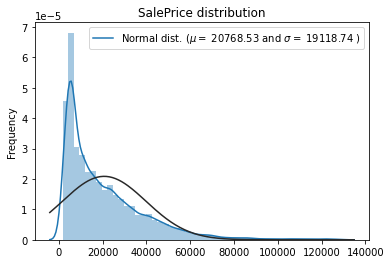

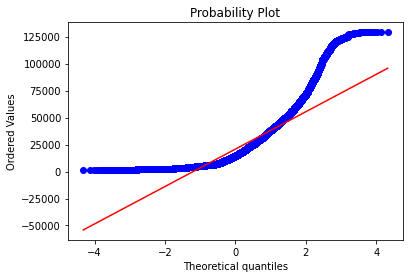

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 9.54 and sigma = 0.93



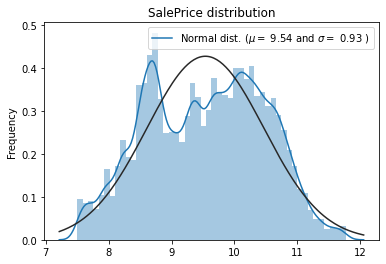

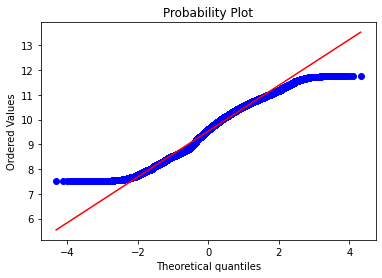

In [ ]:
from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

y = np.log(y)

#Check the new distribution 
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state=42
n_iter=10

num_folds=5

kf = KFold(n_splits=num_folds, random_state=random_state)


from hyperopt import fmin, tpe, hp, anneal, Trials

def gb_mse_cv(params, random_state=random_state, cv=kf, X=x, y=y):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    # we use this params to create a new LGBM Regressor
    model = XGBRegressor(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
#trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = XGBRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(x,y)
tpe_test_score=mean_squared_error(y, model.predict(x))

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


100%|██████████| 10/10 [4:24:42<00:00, 1588.29s/it, best loss: 0.05248649868062579]
[07:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best MSE 0.052 params {'learning_rate': 0.13402021764835548, 'max_depth': 5.0, 'n_estimators': 1644.0}


In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x)
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)





In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.2,
                                   max_depth=10, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

#score = rmsle_cv(GBoost)
#print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.15, max_depth=5, 
                             min_child_weight=1.7817, n_estimators=2000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

#score = rmsle_cv(model_xgb)
#print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,max_depth=10,
                              learning_rate=0.3, n_estimators=5000,
                              max_bin = 55, bagging_fraction = 0.9,
                              bagging_freq = 5, feature_fraction = 0.9,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#score = rmsle_cv(model_lgb)
#print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


In [ ]:
model_cat = CatBoostRegressor(verbose=0,depth= 10, l2_leaf_reg = 1, iterations = 5000, learning_rate = 0.1)

#score = rmsle_cv(model_cat)
#print("Catboost score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

averaged_models = AveragingModels(models = (GBoost, model_xgb,model_lgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

stacked_averaged_models = StackingAveragedModels(base_models = (GBoost, model_xgb,model_cat),
                                                 meta_model = model_lgb)

#score = rmsle_cv(stacked_averaged_models)
#print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
test = pd.read_excel('/content/test1.xlsx')

for i in range(len(cat_col)):
	enc_df = pd.DataFrame(encoded[cat_col[i]].transform(test[[cat_col[i]]]).toarray())
	enc_df.columns = encoded[cat_col[i]].get_feature_names([cat_col[i]])
	test=test.drop(cat_col[i], axis=1)
	test=pd.concat([test, enc_df], axis=1)
test_x=test[independentcols].values

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

stacked_averaged_models.fit(x, y)
stacked_train_pred = stacked_averaged_models.predict(x)
stacked_pred = np.exp(stacked_averaged_models.predict(test_x))
print(rmsle(y, stacked_train_pred))

model_cat.fit(x, y)
cat_train_pred = model_cat.predict(x)
cat_pred = np.exp(model_cat.predict(test_x))
print(rmsle(y, cat_train_pred))


GBoost.fit(x, y)
grad_train_pred = GBoost.predict(x)
grad_pred = np.exp(GBoost.predict(test_x))
print(rmsle(y, grad_train_pred))



0.0819276342212629
0.07424632563510002
0.07878455333566398


In [ ]:
print('RMSLE score on train data:')
print(rmsle(y,stacked_train_pred*0.5 +cat_train_pred*0.49 + grad_train_pred*0.05))

ensemble = cat_pred*0.49 + stacked_pred*0.5 + grad_pred*0.05
test['PREDICTION'] = ensemble

test = test[[primarycol,'PREDICTION']]
test.to_csv('data_cbgridcvgb.csv', sep=';', index=False)

from google.colab import files
files.download('data_cbgridcvgb.csv')

RMSLE score on train data:
0.39003390567241064


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Catboost
model_cat = CatBoostRegressor(verbose=0,cat_features=categorical_features_indices)

grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'depth': [4, 6, 8 , 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'n_estimators': [100, 500 ,1000, 1500, 2000]}

randomized_search_result = model_cat.randomized_search(grid,
                                                    X=x_train,
                                                    y=y_train,
                                                    n_iter=10,
                                                    plot=False)

print(randomized_search_result['params'])

model_cat.fit(x_train, y_train)

pred = model_cat.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,pred)) 
r2 = r2_score(y_test,pred)
print("rmse: ", rmse )
print("r2: ", r2 )

In [ ]:
model_cat = CatBoostRegressor(verbose=0,depth= 10, l2_leaf_reg = 1, iterations = 5000, learning_rate = 0.1)

model_cat.fit(x_train, y_train)

pred = model_cat.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,pred)) 
r2 = r2_score(y_test,pred)
print("rmse: ", rmse )
print("r2: ", r2 )

model_cat.fit(x, y)

pred = model_cat.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,pred)) 
r2 = r2_score(y_test,pred)
print("rmse: ", rmse )
print("r2: ", r2 )

In [ ]:
test = pd.read_excel('/content/test1.xlsx')

for i in range(len(cat_col)):
	enc_df = pd.DataFrame(encoded[cat_col[i]].transform(test[[cat_col[i]]]).toarray())
	enc_df.columns = encoded[cat_col[i]].get_feature_names([cat_col[i]])
	test=test.drop(cat_col[i], axis=1)
	test=pd.concat([test, enc_df], axis=1)
	
test_x=test[independentcols].values
y_pred=model.predict(test_x)

test['PREDICTION'] = y_pred
test = test[[primarycol,'PREDICTION']]
test.to_csv('data_cbgridcv.csv', sep=';', index=False)

from google.colab import files
files.download('data_cbgridcv.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean

def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

df = pd.read_excel('/content/train.xlsx')

primarycol = 'JOBID'
depcol = 'ELAPSEDTIME'
indcol = list(df.columns)
indcol.remove(primarycol)
indcol.remove(depcol)

encoded={}
cat_col=[]
for col, col_type in df.dtypes.iteritems():
      if col_type == 'O':
          cat_col.append(col)
cat_col = [x for x in cat_col if x in indcol]
for i in range(len(cat_col)):
    encoder = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(encoder.fit_transform(df[[cat_col[i]]]).toarray())
    enc_df.columns = encoder.get_feature_names([cat_col[i]])
    df=df.drop(cat_col[i], axis=1)
    df=pd.concat([df, enc_df], axis=1)
    encoded.update({cat_col[i]:encoder})
    
independentcols=list(df.columns)
removecols=[depcol,primarycol]
independentcols = [n for n in independentcols if n not in removecols]

x=df[independentcols].values
y=df[depcol].values

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

level0 = list()
level0.append(('Catboost', CatBoostRegressor(verbose=0)))
level0.append(('Lightbgm', LGBMRegressor(verbose=0)))
#Catboost
level1 = XGBRegressor(verbose=0)

model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)

scores= evaluate_model(model,x, y)
print(mean(scores))



-4504.305630237003


In [ ]:
model_cat.fit(x, y)

pred = model_cat.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,pred)) 
r2 = r2_score(y_test,pred)
print("rmse: ", rmse )
print("r2: ", r2 )


rmse:  3166.8275135005038
r2:  0.9721629037946745


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor

df = pd.read_excel('/content/train.xlsx')

primarycol = 'JOBID'
depcol = 'ELAPSEDTIME'
indcol = list(df.columns)
indcol.remove(primarycol)
indcol.remove(depcol)

encoded={}
cat_col=[]
for col, col_type in df.dtypes.iteritems():
     if col_type == 'O':
          cat_col.append(col)
cat_col = [x for x in cat_col if x in indcol]
for i in range(len(cat_col)):
    encoder = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(encoder.fit_transform(df[[cat_col[i]]]).toarray())
    enc_df.columns = encoder.get_feature_names([cat_col[i]])
    df=df.drop(cat_col[i], axis=1)
    df=pd.concat([df, enc_df], axis=1)
    encoded.update({cat_col[i]:encoder})
    
independentcols=list(df.columns)
removecols=[depcol,primarycol]
independentcols = [n for n in independentcols if n not in removecols]


x=df[independentcols].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=15)
x = pca.fit_transform(x)
y=df[depcol].values

print(x.shape)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

#Catboost
model_cat = CatBoostRegressor(verbose=0)

grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'depth': [4, 6, 8 , 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'n_estimators': [100, 500 ,1000, 1500, 2000, 3000, 4000, 5000]}

randomized_search_result = model_cat.randomized_search(grid,
                                                    X=x_train,
                                                    y=y_train,
                                                    n_iter=10,
                                                    plot=False)

print(randomized_search_result['params'])

model_cat.fit(x, y)

pred = model_cat.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,pred)) 
r2 = r2_score(y_test,pred)
print("rmse: ", rmse )
print("r2: ", r2 )

(89112, 15)

bestTest = 6439.909996
bestIteration = 999

0:	loss: 6439.9099957	best: 6439.9099957 (0)	total: 8.97s	remaining: 1m 20s

bestTest = 4723.125789
bestIteration = 3980

1:	loss: 4723.1257893	best: 4723.1257893 (1)	total: 44.6s	remaining: 2m 58s

bestTest = 4701.823099
bestIteration = 4994

2:	loss: 4701.8230987	best: 4701.8230987 (2)	total: 1m 29s	remaining: 3m 28s

bestTest = 4617.309706
bestIteration = 1494

3:	loss: 4617.3097058	best: 4617.3097058 (3)	total: 1m 49s	remaining: 2m 44s

bestTest = 4744.701836
bestIteration = 999

4:	loss: 4744.7018362	best: 4617.3097058 (3)	total: 2m 14s	remaining: 2m 14s

bestTest = 4564.193299
bestIteration = 1373

5:	loss: 4564.1932992	best: 4564.1932992 (5)	total: 2m 52s	remaining: 1m 54s

bestTest = 6213.098282
bestIteration = 1499

6:	loss: 6213.0982817	best: 4564.1932992 (5)	total: 4m 28s	remaining: 1m 55s

bestTest = 4619.283333
bestIteration = 2999

7:	loss: 4619.2833330	best: 4564.1932992 (5)	total: 7m 41s	remaining: 1m 55s

bestTes

In [ ]:
model_cat = CatBoostRegressor(verbose=0,depth= 10, l2_leaf_reg = 5, iterations = 5000, learning_rate = 0.4)

model_cat.fit(x, y)

pred = model_cat.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test,pred)) 
r2 = r2_score(y_test,pred)
print("rmse: ", rmse )
print("r2: ", r2 )

rmse:  2453.900420737671
r2:  0.9832856696454557


In [ ]:
test = pd.read_excel('/content/test1.xlsx')

for i in range(len(cat_col)):
	enc_df = pd.DataFrame(encoded[cat_col[i]].transform(test[[cat_col[i]]]).toarray())
	enc_df.columns = encoded[cat_col[i]].get_feature_names([cat_col[i]])
	test=test.drop(cat_col[i], axis=1)
	test=pd.concat([test, enc_df], axis=1)
	
test_x=test[independentcols].values

test_x = pca.transform(test_x)

y_pred=model_cat.predict(test_x)

test['PREDICTION'] = y_pred
test = test[[primarycol,'PREDICTION']]
test.to_csv('data_cbgridcv.csv', sep=';', index=False)

from google.colab import files
files.download('data_cbgridcv.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

df = pd.read_csv('/content/csv_result-Descriptors_Training.csv')

X = df.iloc[:, :-1].values
y = df.iloc[:,-1].values
print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

clf = LogisticRegression(random_state=0)

bgclassifier = BaggingClassifier(base_estimator=clf, n_estimators=100, 
                                 max_features=10, 
                                 max_samples=100,
                                 random_state=1, n_jobs=5)

bgclassifier.fit(X_train, y_train)

print('Model test Score: %.3f, ' %bgclassifier.score(X_test, y_test), 
      'Model training Score: %.3f' %bgclassifier.score(X_train, y_train))

In [ ]:
clf = LogisticRegression(random_state=0)

bgclassifier = BaggingClassifier(base_estimator=clf, n_estimators=100, 
                                 max_features=10, 
                                 max_samples=100,
                                 random_state=1, n_jobs=5)

bgclassifier.fit(X_train, y_train)


In [ ]:
print('Model test Score: %.3f, ' %bgclassifier.score(X_test, y_test), 
      'Model training Score: %.3f' %bgclassifier.score(X_train, y_train))


Model test Score: 0.944,  Model training Score: 0.944


In [ ]:
pred = bgclassifier.predict(X_test)
print(pred)

['N' 'N' 'N' ... 'N' 'N' 'N']


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score,accuracy_score
acc = accuracy_score(y_test, pred)
print(acc)
precision = precision_score(y_test, pred,pos_label='N')
print(precision)
recall = recall_score(y_test, pred,pos_label='N')
print(recall)
f1 = f1_score(y_test, pred,pos_label='N')
print(f1)


0.9436439321165546
0.9436439321165546
1.0
0.971004942339374


In [ ]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import keras

In [ ]:
# define base model
def baseline_model():
  model = Sequential()
  model.add(Dense(200, input_dim=32, kernel_initializer='normal', activation='relu'))
  model.add(Dense(100, kernel_initializer='normal', activation='relu'))
  model.add(Dense(50, kernel_initializer='normal', activation='relu'))
  model.add(Dense(25, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
  # Compile model
  model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta())
  return model

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=500, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, x, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
estimator.fit(x,y)

In [ ]:
y_pred = np.expm1(estimator.predict(test_x))

test['PREDICTION'] = y_pred
test = test[[primarycol,'PREDICTION']]
test.to_csv('data_cbgridcv.csv', sep=';', index=False)

from google.colab import files
files.download('data_cbgridcv.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler

X_train = pd.read_csv('/content/train_X.csv',header=None)
X_val = pd.read_csv('/content/test_X.csv',header=None)
y_train = pd.read_csv('/content/train_y.csv',header=None)
y_val = pd.read_csv('/content/test_y.csv',header=None)

In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=2000,
    random_seed=42,
    learning_rate=0.5
)

clf.fit(
    X_train, y_train
)

In [ ]:
#Catboost
model_cat = CatBoostClassifier(verbose=0)

grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'depth': [4, 6, 8 , 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'n_estimators': [100, 500 ,1000, 1500, 2000, 3000, 4000, 5000]}

randomized_search_result = model_cat.randomized_search(grid,
                                                    X=X_train,
                                                    y=y_train,
                                                    n_iter=10,
                                                    plot=False)

print(randomized_search_result['params'])

model_cat.fit(X_train, y_train)


bestTest = 0.1035027714
bestIteration = 999

0:	loss: 0.1035028	best: 0.1035028 (0)	total: 14.2s	remaining: 2m 7s

bestTest = 0.09869015939
bestIteration = 939

1:	loss: 0.0986902	best: 0.0986902 (1)	total: 1m	remaining: 4m 3s

bestTest = 0.09811741803
bestIteration = 1393

2:	loss: 0.0981174	best: 0.0981174 (2)	total: 1m 57s	remaining: 4m 35s

bestTest = 0.09722716292
bestIteration = 315

3:	loss: 0.0972272	best: 0.0972272 (3)	total: 2m 24s	remaining: 3m 36s

bestTest = 0.07653094705
bestIteration = 598

4:	loss: 0.0765309	best: 0.0765309 (4)	total: 3m 3s	remaining: 3m 3s

bestTest = 0.08859089712
bestIteration = 1431

5:	loss: 0.0885909	best: 0.0765309 (4)	total: 3m 54s	remaining: 2m 36s

bestTest = 0.08205748892
bestIteration = 1499

6:	loss: 0.0820575	best: 0.0765309 (4)	total: 6m 34s	remaining: 2m 49s

bestTest = 0.06515943997
bestIteration = 2783

7:	loss: 0.0651594	best: 0.0651594 (7)	total: 11m 35s	remaining: 2m 53s

bestTest = 0.06511426864
bestIteration = 3365

8:	loss: 0.06

In [ ]:
pred = model_cat.predict(data=X_val)

In [ ]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
acc = accuracy_score(y_val, pred)
print(acc)
precision = precision_score(y_val, pred)
print(precision)
recall = recall_score(y_val, pred)
print(recall)
f1 = f1_score(y_val, pred)
print(f1)

model_cat = CatBoostClassifier(verbose=0,'depth': 10, 'l2_leaf_reg': 5, 'iterations': 4000, 'learning_rate': 0.1)

0.9486324216144096
0.5
0.003246753246753247
0.0064516129032258064
